In [37]:
from __future__ import division
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import csv
import datetime
import matplotlib.dates as mdates

from gurobipy import *

from datetime import datetime

# define model parameters from building

Tr: room temperature
Cp: specific heat capacity of air
Ts: supply air temperature
Tm: temperature of the building's lumped thermal mass
Cr: thermal capacitance of the room
Cm: thermal capacitance of the thermal mass
Ta: ambient temperature
Rra: thermal resistance between the room and the ambient
Rrm: thermal resistance between the room and the thermal mass
G: solar irradiance
Sa: solar irradiance absorption factor
Ig: internal heat gain


In [38]:
class BuildingRC(object):
    def _int_(self,
             Infl=0.5):
        self.Infl = Infl

In [39]:
BuildingRC

__main__.BuildingRC

In [40]:
# read the measured data (i.g., EnergyPlus simulation results) 
df = pd.read_csv('../BuiltROM/EPlusModel/Output/MediumOffice_RC.csv')
df.index = pd.date_range('2017-05-01 00:05', '2017-11-01 00:00', freq='5min')

In [41]:
df.rename(columns={'PERIMETER_TOP_ZN_1:Zone Total Internal Total Heating Rate [W](TimeStep)':'PERIMETER_TOP_1_ZN:InternalGains',
                   'PERIMETER_TOP_ZN_2:Zone Total Internal Total Heating Rate [W](TimeStep)':'PERIMETER_TOP_2_ZN:InternalGains',
                   'PERIMETER_TOP_ZN_3:Zone Total Internal Total Heating Rate [W](TimeStep)':'PERIMETER_TOP_3_ZN:InternalGains',
                   'PERIMETER_TOP_ZN_4:Zone Total Internal Total Heating Rate [W](TimeStep)':'PERIMETER_TOP_4_ZN:InternalGains',
                   'CORE_TOP:Zone Total Internal Total Heating Rate [W](TimeStep)':'CORE_TOP_ZN:InternalGains',
                   'PERIMETER_TOP_ZN_1:Zone Windows Total Transmitted Solar Radiation Rate [W](TimeStep)':'PERIMETER_TOP_1_ZN:SolarGains',
                   'PERIMETER_TOP_ZN_2:Zone Windows Total Transmitted Solar Radiation Rate [W](TimeStep)':'PERIMETER_TOP_2_ZN:SolarGains',
                   'PERIMETER_TOP_ZN_3:Zone Windows Total Transmitted Solar Radiation Rate [W](TimeStep)':'PERIMETER_TOP_3_ZN:SolarGains',
                   'PERIMETER_TOP_ZN_4:Zone Windows Total Transmitted Solar Radiation Rate [W](TimeStep)':'PERIMETER_TOP_4_ZN:SolarGains',
                   'PERIMETER_TOP_ZN_1:Zone Air Temperature [C](TimeStep)':'PERIMETER_TOP_1_ZN:ZoneAirTemperature',
                   'PERIMETER_TOP_ZN_2:Zone Air Temperature [C](TimeStep)':'PERIMETER_TOP_2_ZN:ZoneAirTemperature',
                   'PERIMETER_TOP_ZN_3:Zone Air Temperature [C](TimeStep)':'PERIMETER_TOP_3_ZN:ZoneAirTemperature',
                   'PERIMETER_TOP_ZN_4:Zone Air Temperature [C](TimeStep)':'PERIMETER_TOP_4_ZN:ZoneAirTemperature',
                   'CORE_TOP:Zone Air Temperature [C](TimeStep)':'PERIMETER_TOP_CORE_ZN:ZoneAirTemperature',
                   'VAV_3 SUPPLY EQUIPMENT OUTLET NODE:System Node Current Density Volume Flow Rate [m3/s](TimeStep)':'VAV_3_AirFlowRate'},inplace=True)

In [42]:
df.columns

Index(['Date/Time',
       'Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)',
       'Environment:Site Diffuse Solar Radiation Rate per Area [W/m2](TimeStep)',
       'Environment:Site Direct Solar Radiation Rate per Area [W/m2](TimeStep)',
       'CORE_BOTTOM:Zone Total Internal Total Heating Rate [W](TimeStep)',
       'CORE_MID:Zone Total Internal Total Heating Rate [W](TimeStep)',
       'CORE_TOP_ZN:InternalGains',
       'FIRSTFLOOR_PLENUM:Zone Total Internal Total Heating Rate [W](TimeStep)',
       'MIDFLOOR_PLENUM:Zone Total Internal Total Heating Rate [W](TimeStep)',
       'PERIMETER_BOT_ZN_1:Zone Total Internal Total Heating Rate [W](TimeStep)',
       'PERIMETER_BOT_ZN_2:Zone Total Internal Total Heating Rate [W](TimeStep)',
       'PERIMETER_BOT_ZN_3:Zone Total Internal Total Heating Rate [W](TimeStep)',
       'PERIMETER_BOT_ZN_4:Zone Total Internal Total Heating Rate [W](TimeStep)',
       'PERIMETER_MID_ZN_1:Zone Total Internal Total Heating Rate [W](Tim

In [43]:
training_data = df['2017-08-07':'2017-08-11']
# Tr, m, Ta, G, and I
Tr = training_data.filter(regex='ZN:ZoneAirTemperature').mean(axis=1).values
mf = training_data.filter(regex='VAV_3_AirFlowRate').sum(axis=1).values
Ta = training_data.filter(regex='Outdoor Air Drybulb Temperature').values
G = training_data.filter(regex='ZN:SolarGains').sum(axis=1).values
Ig = training_data.filter(regex='ZN:InternalGains').sum(axis=1).values
Ts = training_data.filter(regex='OUTLET NODE NAME:System Node Temperature').mean(axis=1).values

In [44]:
# model
m = Model("RC")

In [45]:
M = len(Tr)
a11 = m.addVar(name='a11')
a12 = m.addVar(name='a12')
a21 = m.addVar(name='a21')
a22 = m.addVar(name='a22')
b = m.addVar(name='b')
d11 = m.addVar(name='d11')
d12 = m.addVar(name='d12')
d13 = m.addVar(name='d13')

Tr_hat = {}
Tm_hat = {}
Tm = {}

for k in range(M):
    Tr_hat[k] = m.addVar(name='Tr_hat_%s' % (k))
#     Tm_hat[k] = m.addVar(name='Tm_hat_%s' % (k))
#     Tm[k] = m.addVar(name='Tm_%s' % (k))
    
# for k in range(M):
#     Tr_hat[k] = m.addVar(name='Tr_hat_%s' % (k))
#     Tm_hat[k] = m.addVar(name='Tm_hat_%s' % (k))
#     Tm[k] = m.addVar(name='Tm_%s' % (k))
    

In [46]:
# constraints
m.addConstr(a11 >= 0, 'c2')
m.addConstr(a12 >= 0, 'c3')
# m.addConstr(a21 >= 0, 'c4')
m.addConstr(b >= 0, 'c5')
m.addConstr(d11 >= 0, 'c6')
m.addConstr(d12 >= 0, 'c7')
m.addConstr(d13 >= 0, 'c8')

for k in range(M-1):
    m.addConstr(Tr_hat[k+1] == (a11)*Tr[k] + b*Ts[k]*mf[k] + (-b)*Tr[k]*mf[k] + d11*Ta[k] + d12*G[k] + d13*Ig[k], 'c0_%s' % (k))

# for k in range(M):
#     m.addConstr(Tr_hat[k] == a11*Tr[k] + a12*Tm[k] + b*Ts[k]*mf[k] + (-b)*Tr[k]*mf[k] + d11*Ta[k] + d12*G[k] + d13*Ig[k], 'c0_%s' % (k))
#     m.addConstr(Tm_hat[k] == a21*Tr[k] + a22*Tm[k], 'c1_%s' % (k))
#     m.addConstr(0.01*Tr[k] <= Tm[k] <= 2.5*Tr[k], 'c2_%s' % (k))
    

In [47]:
# Set objective: 
obj = quicksum((Tr_hat[k] - Tr[k])*(Tr_hat[k] - Tr[k]) for k in range(M))
m.setObjective(obj, GRB.MINIMIZE)

In [48]:
m.optimize()

Optimize a model with 1445 rows, 1448 columns and 7603 nonzeros
Model has 1440 quadratic objective terms
Coefficient statistics:
  Matrix range     [5e-02, 4e+04]
  Objective range  [4e+01, 6e+01]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 6 rows and 4 columns
Presolve time: 0.01s
Presolved: 1439 rows, 1444 columns, 7597 nonzeros
Presolved model has 1439 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 6.158e+03
 Factor NZ  : 7.612e+03 (roughly 1 MByte of memory)
 Factor Ops : 4.116e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.25214854e+08 -3.58874356e+08  2.42e+03 0.00e+00  9.75e+05     0s
   1   8.68997198e+07 -1.04303354e+08  3.28e+00 2.71e+00  1.33e+05     0s
   2   1.32447124e+07 -2.00368286e+07  1.83e-01 1.52e-01 

In [49]:
for v in m.getVars():
    if v.X != 0:
        print("%s %f" % (v.Varname, v.X))

a11 0.991316
b 0.003889
d11 0.009582
d12 0.000000
d13 0.000002
Tr_hat_0 26.231605
Tr_hat_1 26.221151
Tr_hat_2 26.259049
Tr_hat_3 26.280844
Tr_hat_4 26.294420
Tr_hat_5 26.302660
Tr_hat_6 26.307114
Tr_hat_7 26.309002
Tr_hat_8 26.309034
Tr_hat_9 26.307775
Tr_hat_10 26.305609
Tr_hat_11 26.302807
Tr_hat_12 26.299559
Tr_hat_13 26.295986
Tr_hat_14 26.290490
Tr_hat_15 26.283833
Tr_hat_16 26.276332
Tr_hat_17 26.268194
Tr_hat_18 26.259585
Tr_hat_19 26.250617
Tr_hat_20 26.241373
Tr_hat_21 26.231908
Tr_hat_22 26.222263
Tr_hat_23 26.212461
Tr_hat_24 26.202516
Tr_hat_25 26.192468
Tr_hat_26 26.181765
Tr_hat_27 26.170724
Tr_hat_28 26.159435
Tr_hat_29 26.147946
Tr_hat_30 26.136327
Tr_hat_31 26.124641
Tr_hat_32 26.112918
Tr_hat_33 26.101193
Tr_hat_34 26.089467
Tr_hat_35 26.077740
Tr_hat_36 26.066038
Tr_hat_37 26.054358
Tr_hat_38 26.044838
Tr_hat_39 26.036574
Tr_hat_40 26.028553
Tr_hat_41 26.021049
Tr_hat_42 25.893011
Tr_hat_43 25.805291
Tr_hat_44 25.745818
Tr_hat_45 25.702859
Tr_hat_46 25.670208
Tr_hat_

In [50]:
est_Tr = []
estimated = m.getAttr('x', Tr_hat)
for i in range(M):
    est_Tr.append(estimated[i])

In [51]:
from math import sqrt
err=0
for k in range(len(est_Tr)):
    err += (est_Tr[k]-Tr[k])**2
rsme=sqrt(err/len(est_Tr))

In [52]:
print(rsme)

0.21498291448927323


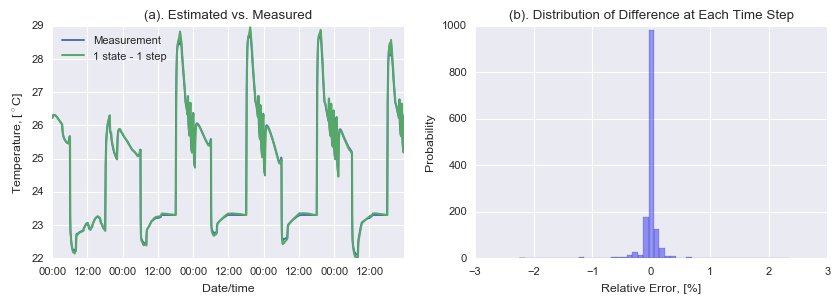

In [35]:
sns.set_context('paper')
fig, (axes) = plt.subplots(1,2, figsize=(10, 3), facecolor='w', edgecolor='k', sharey=False, sharex=False)
fig.subplots_adjust(hspace = .2, wspace=.2)

axes[0].plot(training_data.index, Tr, label='Measurement')
axes[0].plot(training_data.index, est_Tr, label='1 state - 1 step')
sns.distplot((est_Tr - Tr), kde=False, color="b", ax=axes[1])
axes[0].set_xlabel('Date/time')
axes[0].set_ylabel('Temperature, [$^\circ$C]')
axes[0].set_title('(a). Estimated vs. Measured')
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# axes[0].xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=1, interval=1, tz=None))
axes[1].set_xlabel('Relative Error, [%]')
axes[1].set_ylabel('Probability')
axes[1].set_title('(b). Distribution of Difference at Each Time Step')

axes[0].legend(loc='upper left')
# axes[1].legend()

# axes[2].hist(abs(est_Tr - Tr)/est_Tr*100,bins=len(Tr),normed=1,histtype='step',lw=1.5,cumulative=1,label='Absolute Error')
# axes[2].set_xlabel('Absolute Relative Error, [%]')
# axes[2].set_ylabel('Cumulative Distribution Function (CDF)')
# # axes[1].set_title('(b). Hourly Error between the Simulated and Measured')
# axes[2].set_ylim(0, 1.2)
# axes[2].set_title('(c). Cumulative Distribution of Hourly Absolute Error')
# axes[2].legend()

fig.savefig('figures/validate-error-new.png', dpi=300, format='png',bbox_inches='tight')

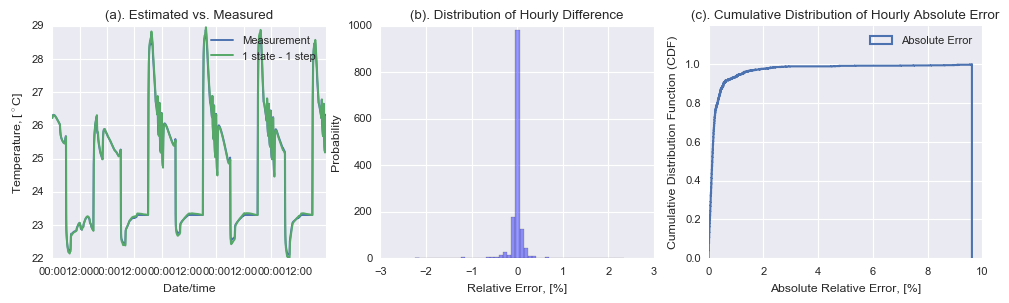

In [36]:
sns.set_context('paper')
fig, (axes) = plt.subplots(1,3, figsize=(12, 3), facecolor='w', edgecolor='k', sharey=False, sharex=False)
fig.subplots_adjust(hspace = .2, wspace=.2)

axes[0].plot(training_data.index, Tr, label='Measurement')
axes[0].plot(training_data.index, est_Tr, label='1 state - 1 step')
sns.distplot((est_Tr - Tr), kde=False, color="b", ax=axes[1])
axes[0].set_xlabel('Date/time')
axes[0].set_ylabel('Temperature, [$^\circ$C]')
axes[0].set_title('(a). Estimated vs. Measured')
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# axes[0].xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=1, interval=1, tz=None))
axes[1].set_xlabel('Relative Error, [%]')
axes[1].set_ylabel('Probability')
axes[1].set_title('(b). Distribution of Hourly Difference')

axes[0].legend()
# axes[1].legend()

axes[2].hist(abs(est_Tr - Tr)/est_Tr*100,bins=len(Tr),normed=1,histtype='step',lw=1.5,cumulative=1,label='Absolute Error')
axes[2].set_xlabel('Absolute Relative Error, [%]')
axes[2].set_ylabel('Cumulative Distribution Function (CDF)')
# axes[1].set_title('(b). Hourly Error between the Simulated and Measured')
axes[2].set_ylim(0, 1.2)
axes[2].set_title('(c). Cumulative Distribution of Hourly Absolute Error')
axes[2].legend()

fig.savefig('figures/validate-error2-new.png', dpi=300, format='png',bbox_inches='tight')

In [121]:
validation_data = df['2017-08-14':'2017-08-15']
# Tr, m, Ta, G, and I
Tr = validation_data.filter(regex='ZN:ZoneAirTemperature').mean(axis=1).values
mf = validation_data.filter(regex='VAV_3_AirFlowRate').sum(axis=1).values
Ta = validation_data.filter(regex='Outdoor Air Drybulb Temperature').values
G = validation_data.filter(regex='ZN:SolarGains').sum(axis=1).values
Ig = validation_data.filter(regex='ZN:InternalGains').sum(axis=1).values
Ts = validation_data.filter(regex='OUTLET NODE NAME:System Node Temperature').mean(axis=1).values

est_Tr = []
a11 = 0.991316
b = 0.003889
d11 = 0.009582
d12 = 0.000000
d13 = 0.000002

# a11 = 0.940231
# b = 0.045134
# d11 = 0.061854
# d12 = 0.000038
# d13 = 0.000023

M = len(validation_data)
est_Tr.append(Tr[0])
for k in range(M-1):
    est = (a11)*Tr[k] + b*Ts[k]*mf[k] + (-b)*Tr[k]*mf[k] + d11*Ta[k] + d12*G[k] + d13*Ig[k]
    est_Tr.append(est)

In [168]:
def modelTest(df, testDay, Tr, mf):
    validation_data = df[testDay]
    # Tr, m, Ta, G, and I
#     Tr = validation_data.filter(regex='ZN:ZoneAirTemperature').mean(axis=1).values
#     mf = validation_data.filter(regex='VAV_3_AirFlowRate').sum(axis=1).values
    Ta = validation_data.filter(regex='Outdoor Air Drybulb Temperature').values
    G = validation_data.filter(regex='ZN:SolarGains').sum(axis=1).values
    Ig = validation_data.filter(regex='ZN:InternalGains').sum(axis=1).values
    Ts = validation_data.filter(regex='OUTLET NODE NAME:System Node Temperature').mean(axis=1).values

    est_Tr = []
    a11 = 0.991316
    b = 0.003889
    d11 = 0.009582
    d12 = 0.000000
    d13 = 0.000002

    # a11 = 0.940231
    # b = 0.045134
    # d11 = 0.061854
    # d12 = 0.000038
    # d13 = 0.000023

    M = len(validation_data)
    est_Tr.append(Tr[0])
    for k in range(M-1):
        est = (a11)*Tr[k] + b*Ts[k]*mf[k] + (-b)*Tr[k]*mf[k] + d11*Ta[k] + d12*G[k] + d13*Ig[k]
        est_Tr.append(est)
    
    return est_Tr

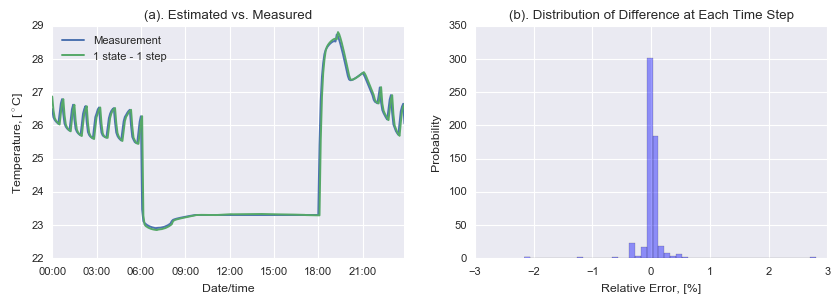

In [126]:
sns.set_context('paper')
fig, (axes) = plt.subplots(1,2, figsize=(10, 3), facecolor='w', edgecolor='k', sharey=False, sharex=False)
fig.subplots_adjust(hspace = .2, wspace=.2)

axes[0].plot(validation_data.index[288:575], Tr[288:575], label='Measurement')
axes[0].plot(validation_data.index[288:575], est_Tr[288:575], label='1 state - 1 step')
sns.distplot(list(est_Tr - Tr), kde=False, color='b', ax=axes[1])
axes[0].set_xlabel('Date/time')
axes[0].set_ylabel('Temperature, [$^\circ$C]')
axes[0].set_title('(a). Estimated vs. Measured')
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# axes[0].xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=1, interval=1, tz=None))
axes[1].set_xlabel('Relative Error, [%]')
axes[1].set_ylabel('Probability')
axes[1].set_title('(b). Distribution of Difference at Each Time Step')

axes[0].legend(loc='upper left')
# axes[1].legend()

# axes[2].hist(abs(est_Tr - Tr)/est_Tr*100,bins=len(Tr),normed=1,histtype='step',lw=1.5,cumulative=1,label='Absolute Error')
# axes[2].set_xlabel('Absolute Relative Error, [%]')
# axes[2].set_ylabel('Cumulative Distribution Function (CDF)')
# # axes[1].set_title('(b). Hourly Error between the Simulated and Measured')
# axes[2].set_ylim(0, 1.2)
# axes[2].set_title('(c). Cumulative Distribution of Hourly Absolute Error')
# axes[2].legend()

fig.savefig('figures/validate-error-4.png', dpi=300, format='png',bbox_inches='tight')

In [109]:
err=0
for k in range(len(est_Tr_DR)):
    err += (est_Tr_DR[k]-Tr[k])**2
rsme=sqrt(err/len(est_Tr))
print(rsme)

0.025682626983508306


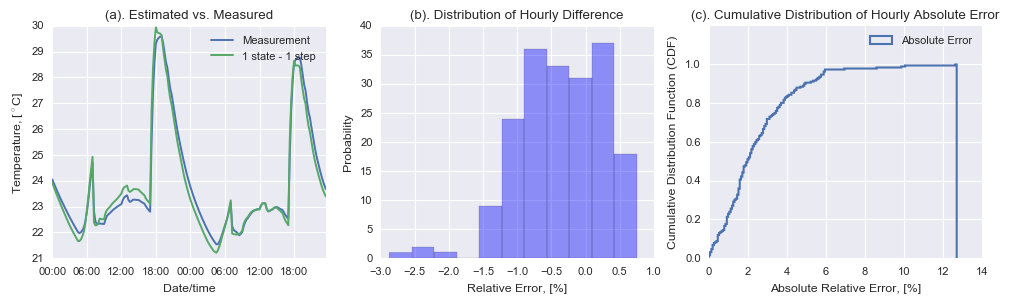

In [52]:
sns.set_context('paper')
fig, (axes) = plt.subplots(1,3, figsize=(12, 3), facecolor='w', edgecolor='k', sharey=False, sharex=False)
fig.subplots_adjust(hspace = .2, wspace=.2)

axes[0].plot(training_data.index[0:191], Tr[0:191], label='Measurement')
axes[0].plot(training_data.index[0:191], est_Tr_DR, label='1 state - 1 step')
sns.distplot((est_Tr - Tr), kde=False, color="b", ax=axes[1])
axes[0].set_xlabel('Date/time')
axes[0].set_ylabel('Temperature, [$^\circ$C]')
axes[0].set_title('(a). Estimated vs. Measured')
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# axes[0].xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=1, interval=1, tz=None))
axes[1].set_xlabel('Relative Error, [%]')
axes[1].set_ylabel('Probability')
axes[1].set_title('(b). Distribution of Hourly Difference')

axes[0].legend()
# axes[1].legend()

axes[2].hist(abs(est_Tr - Tr)/est_Tr*100,bins=len(Tr),normed=1,histtype='step',lw=1.5,cumulative=1,label='Absolute Error')
axes[2].set_xlabel('Absolute Relative Error, [%]')
axes[2].set_ylabel('Cumulative Distribution Function (CDF)')
# axes[1].set_title('(b). Hourly Error between the Simulated and Measured')
axes[2].set_ylim(0, 1.2)
axes[2].set_title('(c). Cumulative Distribution of Hourly Absolute Error')
axes[2].legend()

fig.savefig('figures/validate-error.png', dpi=300, format='png',bbox_inches='tight')

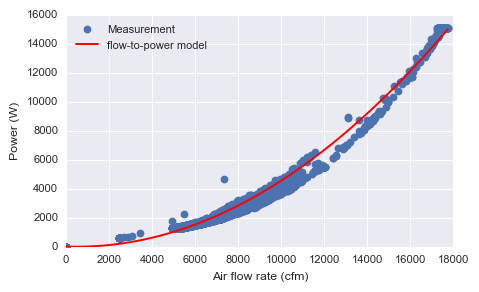

In [61]:
# m/s to cfm
fanFlow = df.filter(regex='VAV_3_AirFlowRate').mean(axis=1).values * 2118.88
fanPower = df.filter(regex='VAV_3_FAN:Fan Electric Power').mean(axis=1).values

fig, ax = plt.subplots(figsize=(5, 3), facecolor='w', edgecolor='k', sharey=False, sharex=False)
fig.subplots_adjust(hspace = .2, wspace=.2)

z1 = np.polyfit(fanFlow, fanPower, 2)
p1 = np.poly1d(z1)
xp1 = np.linspace(min(fanFlow), max(fanFlow), 100)
ax.set_xlabel('Air flow rate (cfm)')
ax.set_ylabel('Power (W)')
ax.plot(fanFlow, fanPower, 'o', label = 'Measurement')
ax.plot(xp1, p1(xp1), '-', label = 'flow-to-power model', color='red')
plt.gca().set_ylim(bottom=0)
# ax.set_title('(a). Estimated vs. Measured')
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# axes[0].xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=1, interval=1, tz=None))

ax.legend(loc='upper left')
fig.savefig('figures/fan-model.png', dpi=300, format='png',bbox_inches='tight')

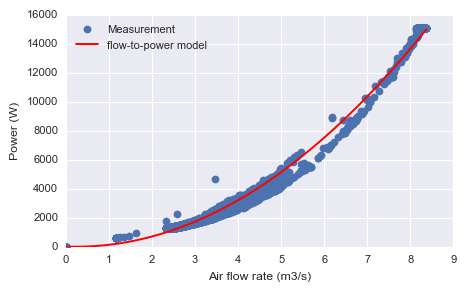

In [83]:
# m/s to cfm
fanFlow = df.filter(regex='VAV_3_AirFlowRate').mean(axis=1).values
fanPower = df.filter(regex='VAV_3_FAN:Fan Electric Power').mean(axis=1).values

fig, ax = plt.subplots(figsize=(5, 3), facecolor='w', edgecolor='k', sharey=False, sharex=False)
fig.subplots_adjust(hspace = .2, wspace=.2)

z1 = np.polyfit(fanFlow, fanPower, 2)
fanCurve = np.poly1d(z1)
xp1 = np.linspace(min(fanFlow), max(fanFlow), 100)
ax.set_xlabel('Air flow rate (m3/s)')
ax.set_ylabel('Power (W)')
ax.plot(fanFlow, fanPower, 'o', label = 'Measurement')
ax.plot(xp1, p1(xp1), '-', label = 'flow-to-power model', color='red')
plt.gca().set_ylim(bottom=0)
# ax.set_title('(a). Estimated vs. Measured')
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# axes[0].xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=1, interval=1, tz=None))

ax.legend(loc='upper left')
fig.savefig('figures/fan-model-2.png', dpi=300, format='png',bbox_inches='tight')

In [84]:
fanCurve

poly1d([ 226.0215373 , -106.33633971,   50.35215515])

In [171]:
P_fan = fanFlow*fanFlow * p1[2] + p1[1]*fanFlow + p1[0]
print(str('{:.2f}'.format(p1[2]))+'*X^2 + ' + str('{:.2f}'.format(p1[1]))+'*X + ' + str('{:.2f}'.format(p1[0])))

226.02*X^2 + -106.34*X + 50.35


In [95]:
def power2Flow(controlFanPower, fanCurve, fanPower):
    if controlFanPower < 0:
        print('Fan Power needs to be positive!')
    elif (controlFanPower > fanPower.max()) or (controlFanPower < fanPower.min()):
        print('Fan Power Input needs to be within the upper and lower fan power limits!')
    else:
        return (-fanCurve[1]+sqrt(fanCurve[1]**2-4*(fanCurve[0]-controlFanPower)*fanCurve[2]))/(2*fanCurve[2])

In [96]:
power2Flow(9000, fanCurve, fanPower)

6.5322004105645499

In [153]:
def readOutputCSV(csvfile):
    df = pd.read_csv(csvfile)
    df.index = pd.date_range('2017-01-01 00:05', '2018-01-01 00:00', freq='5min')
    df['month'] = df.index.map(lambda x: int(x.strftime('%m')))
    df['hour'] = df.index.map(lambda x: int(x.strftime('%H')))
    df['minute'] = df.index.map(lambda x: int(x.strftime('%M')))
    df['weekday'] = df.index.map(lambda x: int(x.strftime('%w')))
    
    data = df['2017-05-01':'2017-10-31'].copy()
    # max cooling power
    data.rename(columns={'PERIMETER_TOP_ZN_1:Zone Total Internal Total Heating Rate [W](TimeStep)':'PERIMETER_TOP_1_ZN:InternalGains',
                   'PERIMETER_TOP_ZN_2:Zone Total Internal Total Heating Rate [W](TimeStep)':'PERIMETER_TOP_2_ZN:InternalGains',
                   'PERIMETER_TOP_ZN_3:Zone Total Internal Total Heating Rate [W](TimeStep)':'PERIMETER_TOP_3_ZN:InternalGains',
                   'PERIMETER_TOP_ZN_4:Zone Total Internal Total Heating Rate [W](TimeStep)':'PERIMETER_TOP_4_ZN:InternalGains',
                   'CORE_TOP:Zone Total Internal Total Heating Rate [W](TimeStep)':'CORE_TOP_ZN:InternalGains',
                   'PERIMETER_TOP_ZN_1:Zone Windows Total Transmitted Solar Radiation Rate [W](TimeStep)':'PERIMETER_TOP_1_ZN:SolarGains',
                   'PERIMETER_TOP_ZN_2:Zone Windows Total Transmitted Solar Radiation Rate [W](TimeStep)':'PERIMETER_TOP_2_ZN:SolarGains',
                   'PERIMETER_TOP_ZN_3:Zone Windows Total Transmitted Solar Radiation Rate [W](TimeStep)':'PERIMETER_TOP_3_ZN:SolarGains',
                   'PERIMETER_TOP_ZN_4:Zone Windows Total Transmitted Solar Radiation Rate [W](TimeStep)':'PERIMETER_TOP_4_ZN:SolarGains',
                   'PERIMETER_TOP_ZN_1:Zone Air Temperature [C](TimeStep)':'PERIMETER_TOP_1_ZN:ZoneAirTemperature',
                   'PERIMETER_TOP_ZN_2:Zone Air Temperature [C](TimeStep)':'PERIMETER_TOP_2_ZN:ZoneAirTemperature',
                   'PERIMETER_TOP_ZN_3:Zone Air Temperature [C](TimeStep)':'PERIMETER_TOP_3_ZN:ZoneAirTemperature',
                   'PERIMETER_TOP_ZN_4:Zone Air Temperature [C](TimeStep)':'PERIMETER_TOP_4_ZN:ZoneAirTemperature',
                   'CORE_TOP:Zone Air Temperature [C](TimeStep)':'PERIMETER_TOP_CORE_ZN:ZoneAirTemperature',
                   'VAV_3 SUPPLY EQUIPMENT OUTLET NODE:System Node Current Density Volume Flow Rate [m3/s](TimeStep)':'VAV_3_AirFlowRate'},inplace=True)

    data['Tr'] = data.filter(regex='ZN:ZoneAirTemperature').mean(axis=1).values
    data['mf'] = data.filter(regex='VAV_3_AirFlowRate').sum(axis=1).values
    data['Ta'] = data.filter(regex='Outdoor Air Drybulb Temperature').values
    data['G'] = data.filter(regex='ZN:SolarGains').sum(axis=1).values
    data['Ig'] = data.filter(regex='ZN:InternalGains').sum(axis=1).values
    data['Ts'] = list(data.filter(regex='OUTLET NODE NAME:System Node Temperature').mean(axis=1).values)
    
    return data

In [154]:
DR = readOutputCSV('EPlusModel/Output/MediumOffice_DR.csv')

In [155]:
DR.columns

Index(['Date/Time',
       'Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)',
       'Environment:Site Diffuse Solar Radiation Rate per Area [W/m2](TimeStep)',
       'Environment:Site Direct Solar Radiation Rate per Area [W/m2](TimeStep)',
       'CORE_BOTTOM:Zone Total Internal Total Heating Rate [W](TimeStep)',
       'CORE_MID:Zone Total Internal Total Heating Rate [W](TimeStep)',
       'CORE_TOP_ZN:InternalGains',
       'FIRSTFLOOR_PLENUM:Zone Total Internal Total Heating Rate [W](TimeStep)',
       'MIDFLOOR_PLENUM:Zone Total Internal Total Heating Rate [W](TimeStep)',
       'PERIMETER_BOT_ZN_1:Zone Total Internal Total Heating Rate [W](TimeStep)',
       'PERIMETER_BOT_ZN_2:Zone Total Internal Total Heating Rate [W](TimeStep)',
       'PERIMETER_BOT_ZN_3:Zone Total Internal Total Heating Rate [W](TimeStep)',
       'PERIMETER_BOT_ZN_4:Zone Total Internal Total Heating Rate [W](TimeStep)',
       'PERIMETER_MID_ZN_1:Zone Total Internal Total Heating Rate [W](Tim

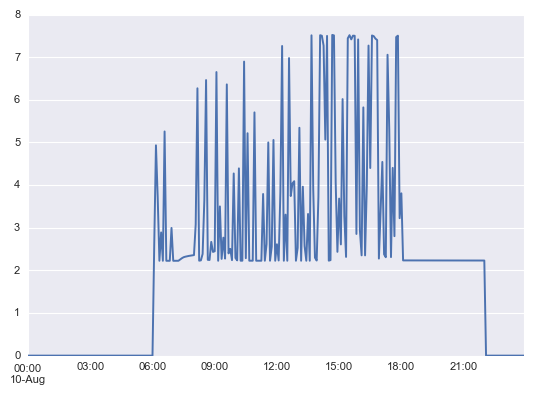

In [158]:
DR['2017-08-10']['mf'].plot()

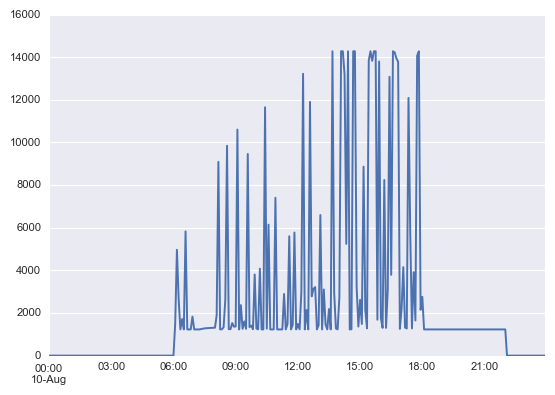

In [176]:
DR['2017-08-10']['VAV_3_FAN:Fan Electric Power [W](TimeStep)'].plot()

In [169]:
test_mf = DR['2017-08-10']['mf'].values
test_Tr = DR['2017-08-10']['Tr'].values
test_estTr = modelTest(df, '2017-08-10', test_Tr, test_mf)

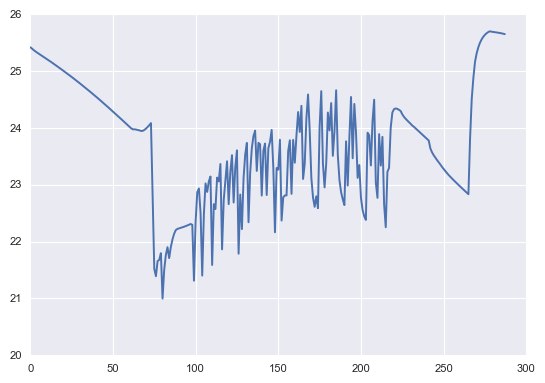

In [170]:
plt.plot(test_estTr)

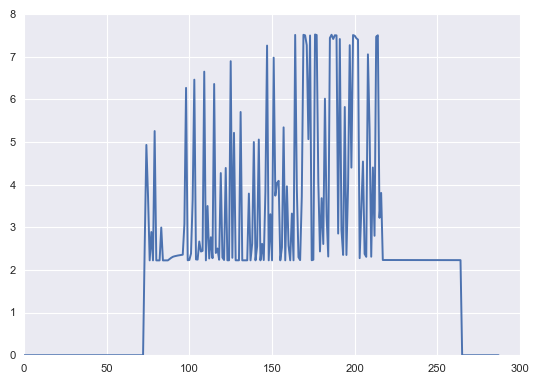

In [166]:
plt.plot(test_mf)

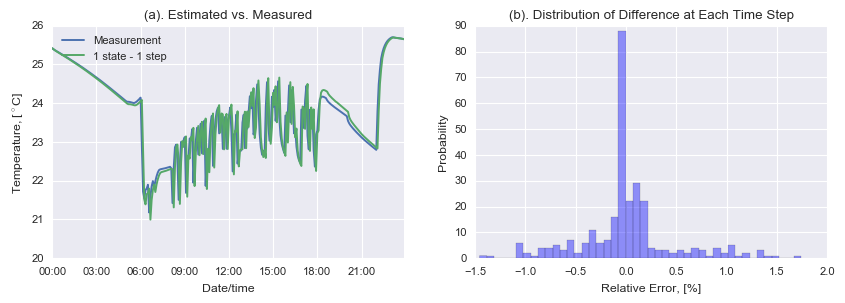

In [175]:
sns.set_context('paper')
fig, (axes) = plt.subplots(1,2, figsize=(10, 3), facecolor='w', edgecolor='k', sharey=False, sharex=False)
fig.subplots_adjust(hspace = .2, wspace=.2)

axes[0].plot(DR['2017-08-10']['Tr'].index, test_Tr, label='Measurement')
axes[0].plot(DR['2017-08-10']['Tr'].index, test_estTr, label='1 state - 1 step')
sns.distplot(list(test_estTr - test_Tr), kde=False, color='b', ax=axes[1])
axes[0].set_xlabel('Date/time')
axes[0].set_ylabel('Temperature, [$^\circ$C]')
axes[0].set_title('(a). Estimated vs. Measured')
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# axes[0].xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=1, interval=1, tz=None))
axes[1].set_xlabel('Relative Error, [%]')
axes[1].set_ylabel('Probability')
axes[1].set_title('(b). Distribution of Difference at Each Time Step')

axes[0].legend(loc='upper left')
# axes[1].legend()

# axes[2].hist(abs(est_Tr - Tr)/est_Tr*100,bins=len(Tr),normed=1,histtype='step',lw=1.5,cumulative=1,label='Absolute Error')
# axes[2].set_xlabel('Absolute Relative Error, [%]')
# axes[2].set_ylabel('Cumulative Distribution Function (CDF)')
# # axes[1].set_title('(b). Hourly Error between the Simulated and Measured')
# axes[2].set_ylim(0, 1.2)
# axes[2].set_title('(c). Cumulative Distribution of Hourly Absolute Error')
# axes[2].legend()

fig.savefig('figures/fanPower-temp.png', dpi=300, format='png',bbox_inches='tight')

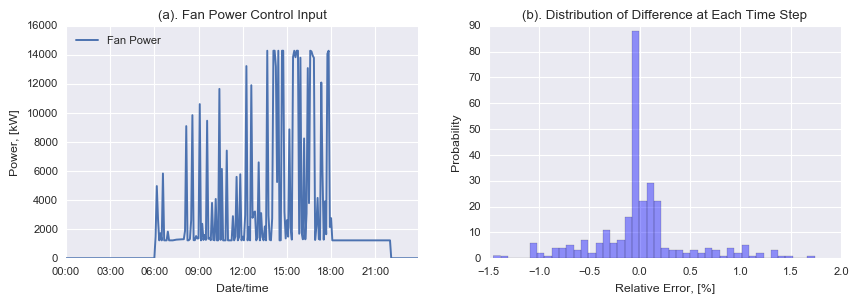

In [178]:
sns.set_context('paper')
fig, (axes) = plt.subplots(1,2, figsize=(10, 3), facecolor='w', edgecolor='k', sharey=False, sharex=False)
fig.subplots_adjust(hspace = .2, wspace=.2)

axes[0].plot(DR['2017-08-10']['Tr'].index, DR['2017-08-10']['VAV_3_FAN:Fan Electric Power [W](TimeStep)'], label='Fan Power')
# axes[0].plot(DR['2017-08-10']['Tr'].index, test_estTr, label='1 state - 1 step')
sns.distplot(list(test_estTr - test_Tr), kde=False, color='b', ax=axes[1])
axes[0].set_xlabel('Date/time')
axes[0].set_ylabel('Power, [kW]')
axes[0].set_title('(a). Fan Power Control Input')
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# axes[0].xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=1, interval=1, tz=None))
axes[1].set_xlabel('Relative Error, [%]')
axes[1].set_ylabel('Probability')
axes[1].set_title('(b). Distribution of Difference at Each Time Step')

axes[0].legend(loc='upper left')
# axes[1].legend()

# axes[2].hist(abs(est_Tr - Tr)/est_Tr*100,bins=len(Tr),normed=1,histtype='step',lw=1.5,cumulative=1,label='Absolute Error')
# axes[2].set_xlabel('Absolute Relative Error, [%]')
# axes[2].set_ylabel('Cumulative Distribution Function (CDF)')
# # axes[1].set_title('(b). Hourly Error between the Simulated and Measured')
# axes[2].set_ylim(0, 1.2)
# axes[2].set_title('(c). Cumulative Distribution of Hourly Absolute Error')
# axes[2].legend()

fig.savefig('figures/fanPower.png', dpi=300, format='png',bbox_inches='tight')